In [19]:
# import sys
# !{sys.executable} -m pip install --upgrade tensorflow 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
import janitor
import tabulate
from tqdm import tqdm
from IPython.display import display, HTML
import geopy
# display(HTML("<style>.container { width:85% !important; }</style>"))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

RS = range(0,25,1)


In [20]:
rootdir = 'zults/'
predictions = pd.DataFrame()
deviations = pd.DataFrame()
for file in tqdm(os.listdir(rootdir)):
    if 'predictions' in file:
        file_reader = pd.read_csv(rootdir + file)
        predictions = predictions.append(file_reader, ignore_index = True)
    
    if 'deviations' in file:
        
        file_reader = pd.read_csv(rootdir + file)
        deviations = deviations.append(file_reader, ignore_index = True)
        
deviations = deviations.drop('Unnamed: 0', axis = 1)

predictions = predictions.drop('Unnamed: 0', axis = 1)

100%|██████████| 35/35 [00:00<00:00, 478.80it/s]


In [21]:
# drops = deviations[deviations['df'] == ''].index
# deviations = deviations.drop(drops)
deviations = deviations[deviations['df'] == 'df4']

# deviations = deviations[deviations['epochs'] == ]

deviations = deviations.sort_values(['test mae avg', 'test predicted thickness std dev'])
deviations

,layer architecture,model parameters,total inputs,df,dropout,learning rate,validation split,epochs,test mae avg,train mae avg,test mae std dev,train mae std dev,test predicted thickness std dev,train predicted thickness std dev
23,32-16,884.0,2556.0,df4,1,0.010,0.2,300,13.445142,9.611069,0.753698,0.437164,1.656730,1.190310
24,40-20,1260.0,2556.0,df4,1,0.010,0.2,300,13.558179,9.263928,0.737184,0.583611,1.423694,1.000863
25,10-5,180.0,2556.0,df4,1,0.100,0.2,300,13.679093,10.274801,1.173249,0.702215,2.524594,2.041050
26,50-25,1820.0,2556.0,df4,1,0.010,0.2,100,13.723141,10.686757,0.507108,0.364087,0.953360,0.786251
9,10-5,180.0,2556.0,df4,0,0.010,0.2,300,13.748538,10.483727,0.636736,0.429107,0.788083,0.627858
27,60-30,2480.0,2556.0,df4,1,0.010,0.2,100,13.783084,10.612955,0.557500,0.371064,1.082833,1.134451
28,40-20,1260.0,2556.0,df4,1,0.010,0.2,100,13.803734,10.769834,0.529826,0.266076,1.122248,1.006257
29,32-16,884.0,2556.0,df4,1,0.001,0.2,300,13.808614,11.297548,0.297330,0.225285,0.422744,0.243287
30,32-16,884.0,2556.0,df4,1,0.010,0.2,100,13.855822,10.876570,0.590728,0.386008,0.947843,0.833678
31,32-16,884.0,2556.0,df4,1,0.100,0.2,300,13.921659,8.184264,1.794344,0.859352,3.309978,2.591270


In [15]:
# select dataset to analyze

selected_dataset = 'df4'
dropout = True

if dropout == True:
    dropout = '1'
    
elif dropout == False:
    dropout = '0'

if selected_dataset == 'df01':
    df01 = gl.data_loader_01()
    gl.thickness_renamer(df01)
    module = 'sm01'
    res = 'sr01'
    dataset = df01
    dataset.name = selected_dataset

if selected_dataset == 'df02':
    df02 = gl.data_loader_02()
    gl.thickness_renamer(df02)
    module = 'sm02'
    res = 'sr02'
    dataset = df02
    dataset.name = selected_dataset
    
    
if selected_dataset == 'df031':
    df031 = gl.data_loader_031()
    gl.thickness_renamer(df031)
    module = 'sm031'
    res = 'sr031'
    dataset = df031
    dataset.name = selected_dataset
    
if selected_dataset == 'df1':
    df1 = gl.data_loader_1()
    gl.thickness_renamer(df1)
    module = 'sm1'
    res = 'sr1'
    dataset = df1
    dataset.name = selected_dataset

if selected_dataset == 'df2':
    df2 = gl.data_loader_2()
    gl.thickness_renamer(df2)
    module = 'sm2'
    res = 'sr2'
    dataset = df2
    dataset.name = selected_dataset
    
if selected_dataset == 'df3':
    df3 = gl.data_loader_3()
    gl.thickness_renamer(df3)
    module = 'sm3'
    res = 'sr3'
    dataset = df3
    dataset.name = selected_dataset
    
if selected_dataset == 'df4':
    df4 = gl.data_loader_4()
    gl.thickness_renamer(df4)
    module = 'sm4'
    res = 'sr4'
    dataset = df4
    dataset.name = selected_dataset
    
if selected_dataset == 'df5':
    df5 = gl.data_loader_5()
    module = 'sm5'
    res = 'sr5'
    reg = df5['region'].iloc[-1]
    df5 = df5.drop('region', axis=1)
    dataset = df5
    dataset.name = str('df5_' + str(reg))


if selected_dataset == 'df6':
    df6 = gl.data_loader_6()
    module = 'sm6'
    res = 'sr6'
    reg = df6['region'].iloc[-1]
    df6 = df6.drop('region', axis=1)
    dataset = df6 
    dataset.name = str('df6_' + str(reg))


matching GlaThiDa and RGI data method 4...


In [18]:
inputs = (len(dataset) * (len(dataset.columns) -1))
print(inputs)
l1arch = 60
l2arch = 30

l3arch = 1


pl1 = l1arch * (len(dataset.columns))

pl2 = l2arch * (l1arch + 1)

pl3 = l3arch * (l2arch + 1)

parameters = pl1 + pl2 + pl3
print(parameters)


2556
2461


In [6]:
RGI_predicted = pd.read_csv('zults/RGI_predicted_df01_1_24-12_0.01_100.csv')

RGI_predicted['volume'] = (
    RGI_predicted['avg predicted thickness'] / 10**3
) * RGI_predicted['area']
RGI_predicted['variance'] = RGI_predicted['predicted thickness std dev'] **2 
total_volume = sum(RGI_predicted['volume'])
variance = sum(RGI_predicted['variance'])
print(total_volume/1e3)
print(np.sqrt(variance)/1e3)
ratio = total_volume / np.sqrt(variance)
print(ratio)

627.1277825906941
5.632631448102144
111.33833064863462


In [7]:
RGI_predicted = pd.read_csv('zults/RGI_predicted_df031_1_40-30_0.01_25.csv')

RGI_predicted['volume'] = (
    RGI_predicted['avg predicted thickness'] / 10**3
) * RGI_predicted['Area']
RGI_predicted['variance'] = RGI_predicted['predicted thickness std dev'] **2 
total_volume = sum(RGI_predicted['volume'])
variance = sum(RGI_predicted['variance'])
print(total_volume/1e3)
print(np.sqrt(variance)/1e3)
ratio = total_volume / np.sqrt(variance)
print(ratio)

511.0423625246282
4.072585019583288
125.48353443015874


In [8]:
RGI_predicted = pd.read_csv('zults/RGI_predicted_df4_1_40-20_0.01_35.csv')

RGI_predicted['volume'] = (
    RGI_predicted['avg predicted thickness'] / 10**3
) * RGI_predicted['Area']
RGI_predicted['variance'] = RGI_predicted['predicted thickness std dev'] **2 
total_volume = sum(RGI_predicted['volume'])
variance = sum(RGI_predicted['variance'])
print(total_volume/1e3)
print(np.sqrt(variance)/1e3)


10078.830139658221
148.25459123517174
67.98325809465474


In [9]:
RGI_predicted = pd.read_csv('zults/RGI_predicted_df4_1_50-25_0.01_35.csv')

RGI_predicted['volume'] = (
    RGI_predicted['avg predicted thickness'] / 10**3
) * RGI_predicted['Area']
RGI_predicted['variance'] = RGI_predicted['predicted thickness std dev'] **2 
total_volume = sum(RGI_predicted['volume'])
variance = sum(RGI_predicted['variance'])
print(total_volume/1e3)
print(np.sqrt(variance)/1e3)


10402.619178976232
141.5270356747022
73.50269953287581


In [10]:
RGI_predicted = pd.read_csv('zults/RGI_predicted_df4_1_64-32_0.01_35.csv')

RGI_predicted['volume'] = (
    RGI_predicted['avg predicted thickness'] / 10**3
) * RGI_predicted['Area']
RGI_predicted['variance'] = RGI_predicted['predicted thickness std dev'] **2 
total_volume = sum(RGI_predicted['volume'])
variance = sum(RGI_predicted['variance'])
print(total_volume/1e3)
print(np.sqrt(variance)/1e3)


10755.377787473331
130.05267372847914
82.70016662577929


Please select index from deviations table to inspect further
27
loading and evaluating models...


100%|██████████| 25/25 [00:06<00:00,  4.13it/s]
/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


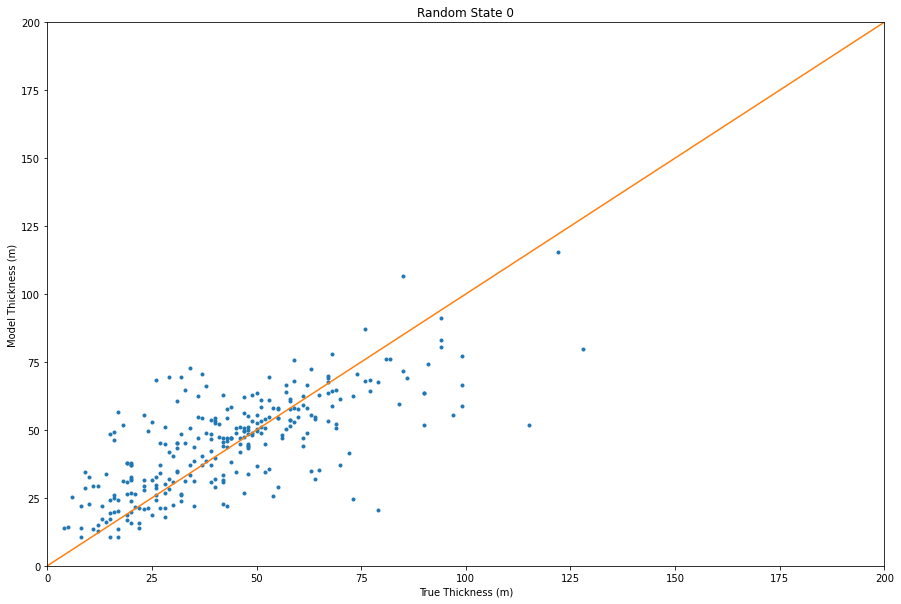

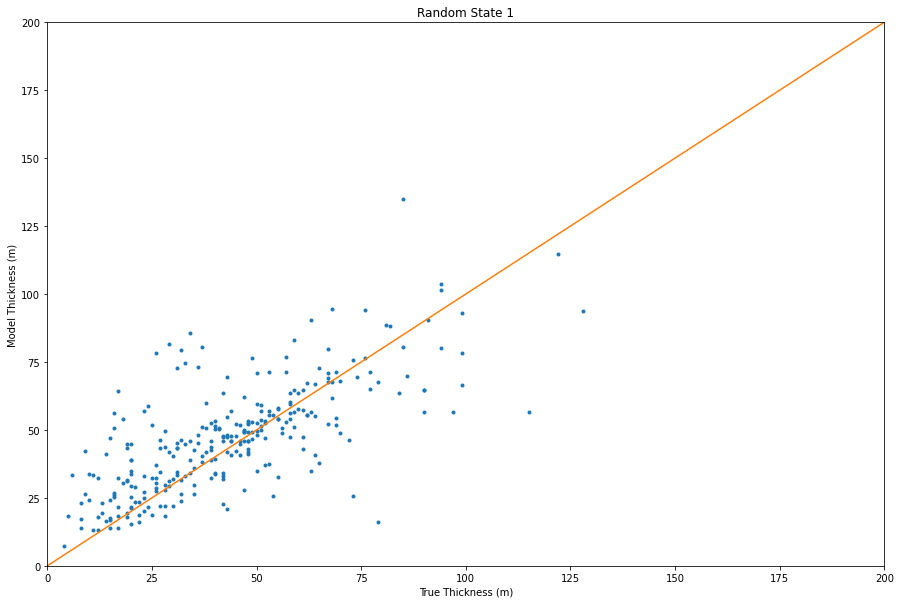

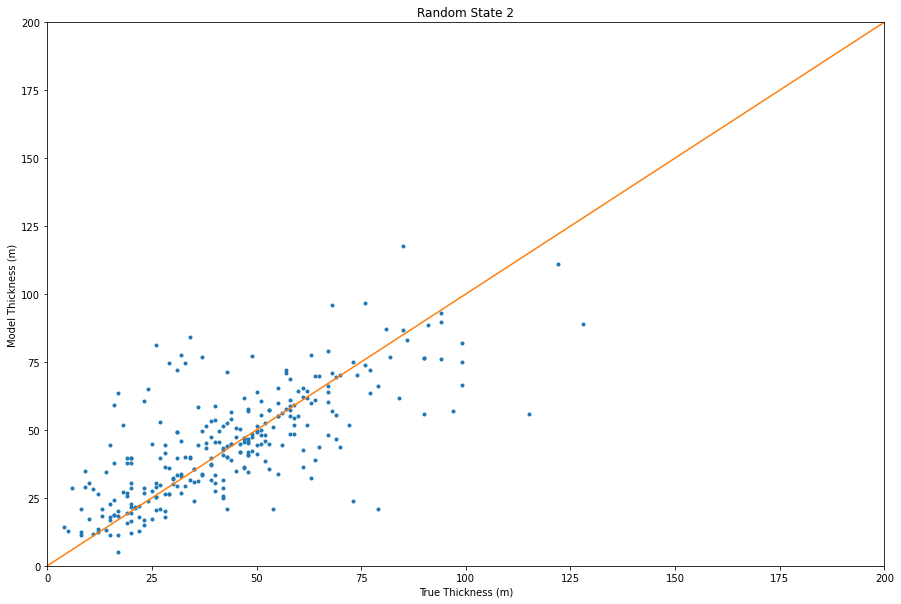

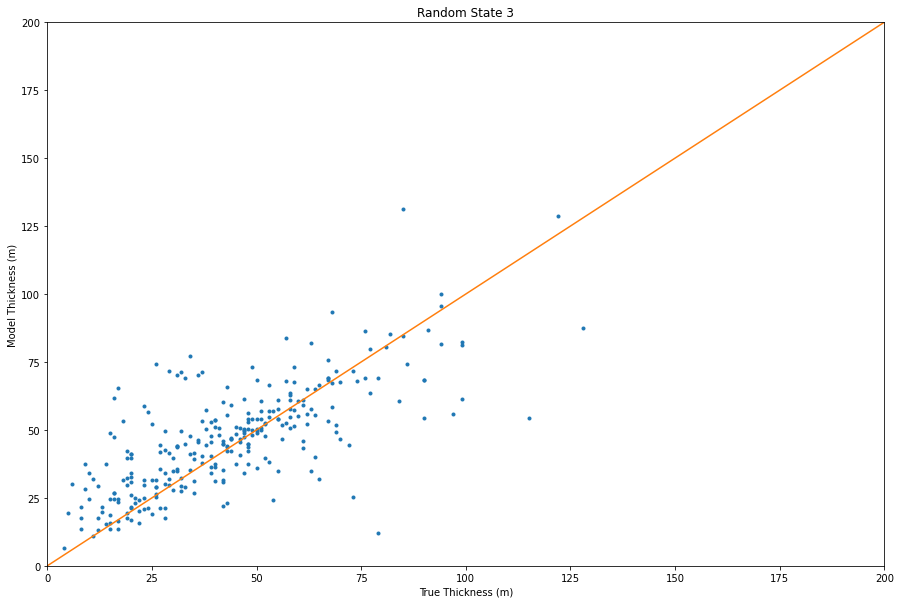

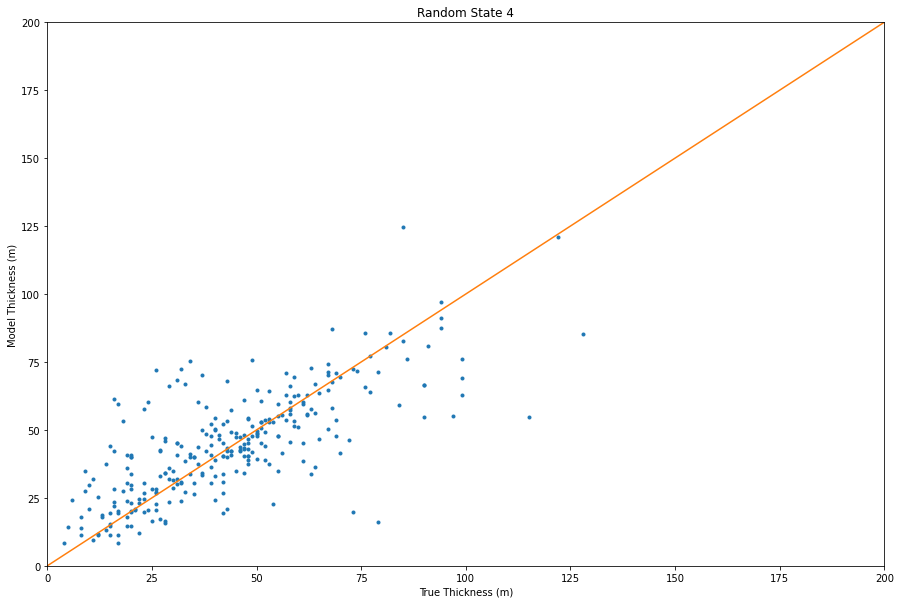

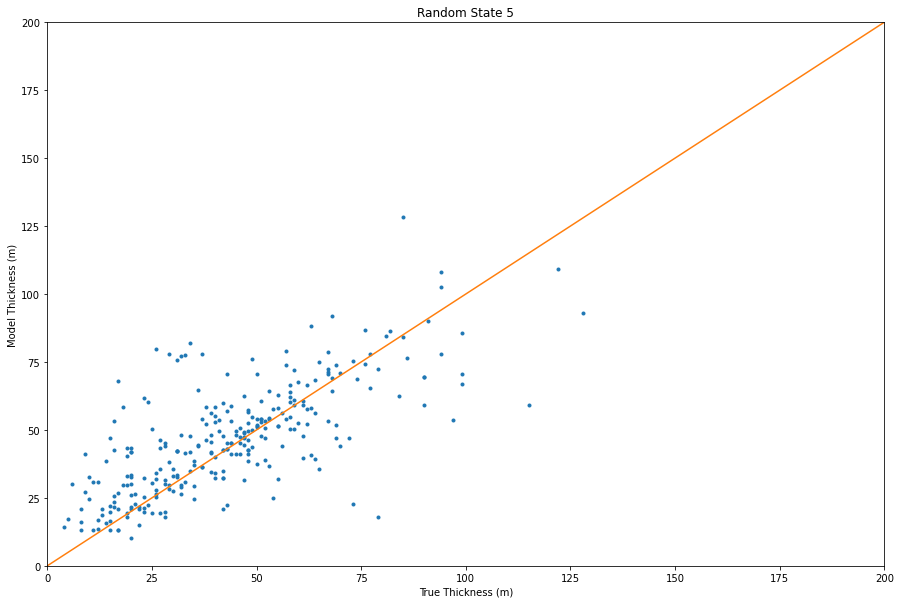

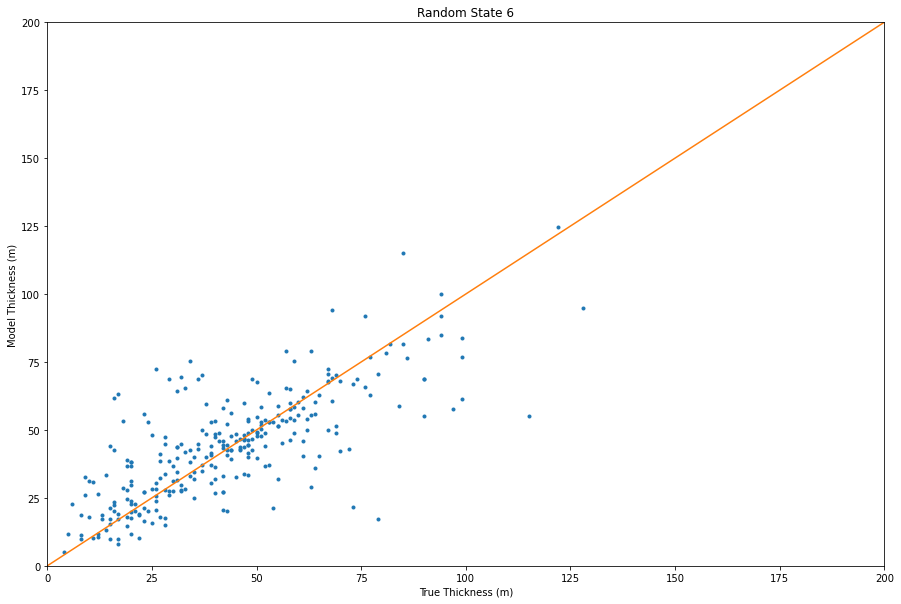

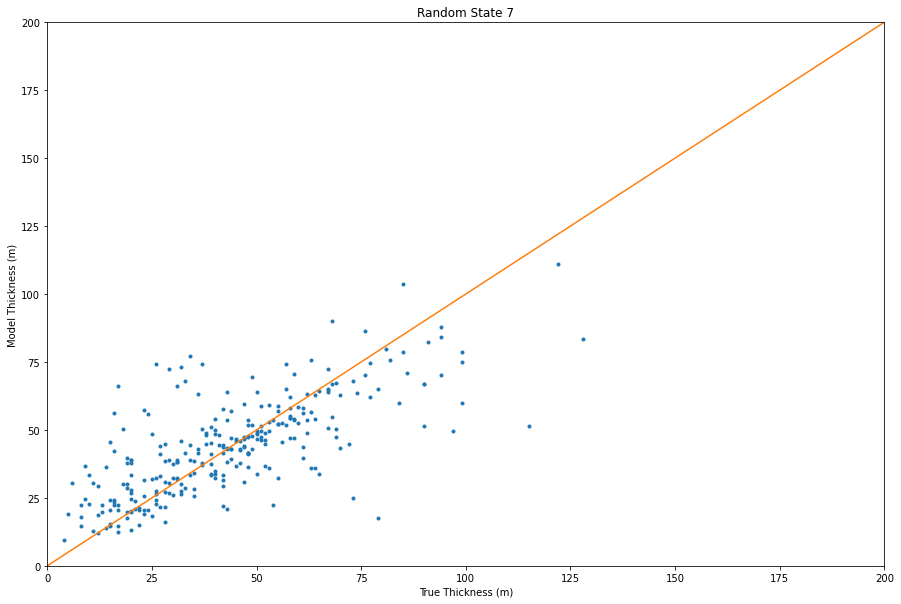

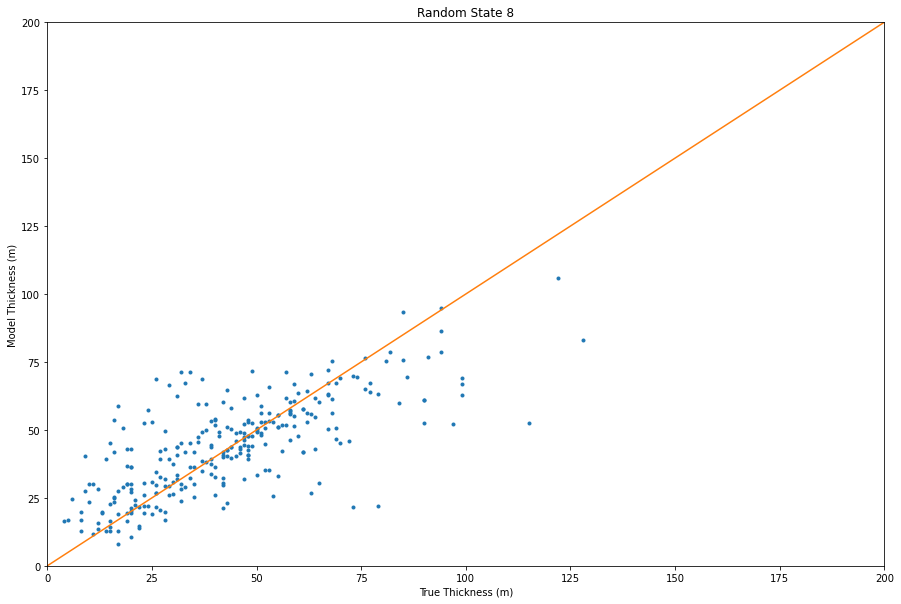

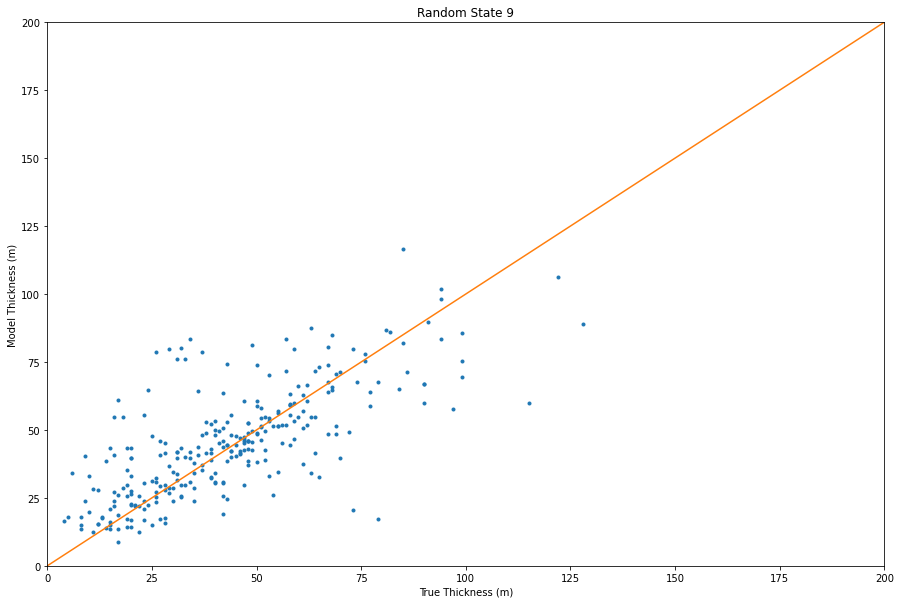

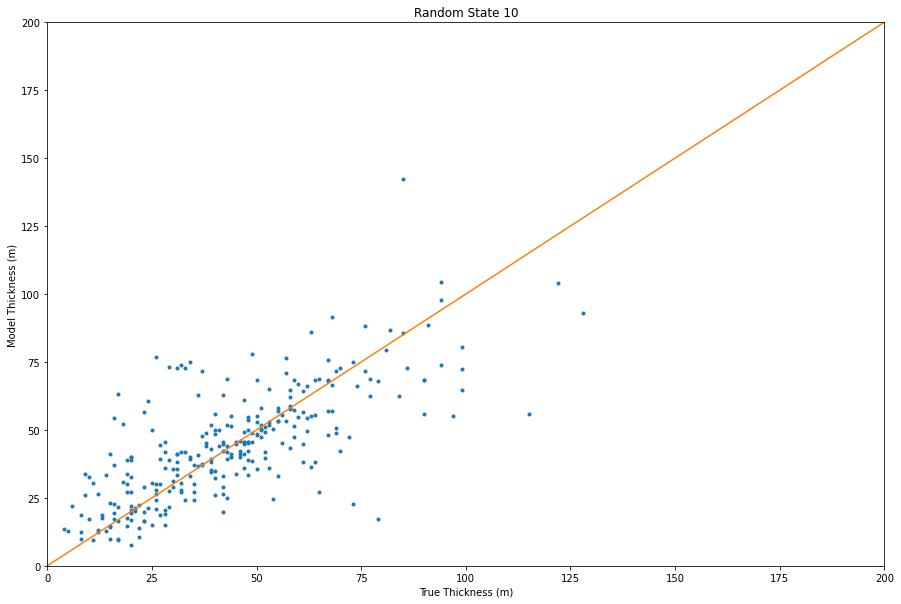

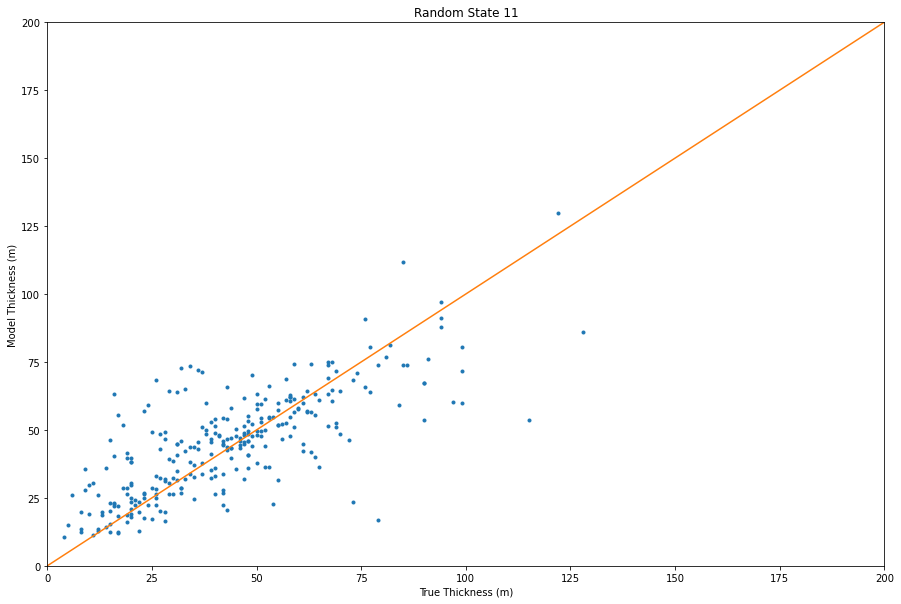

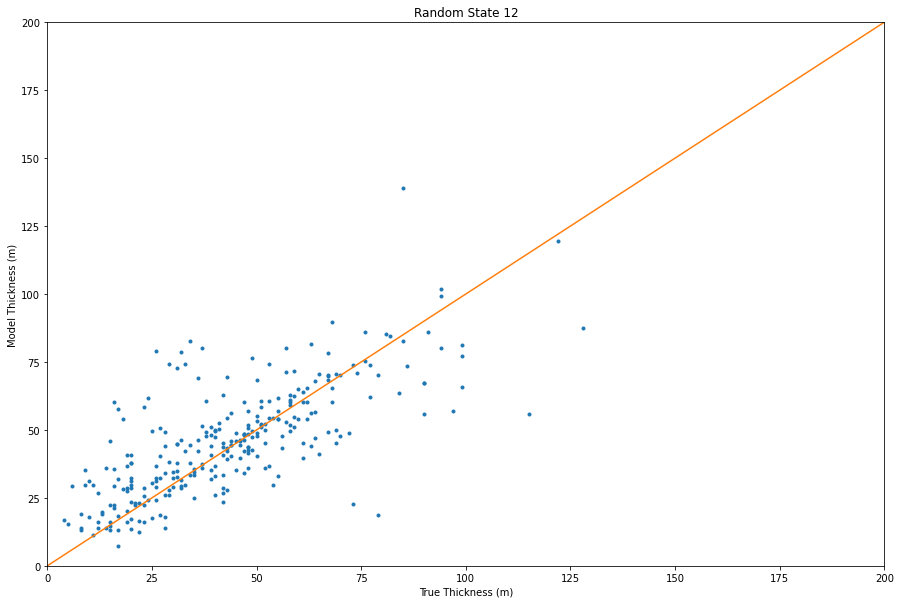

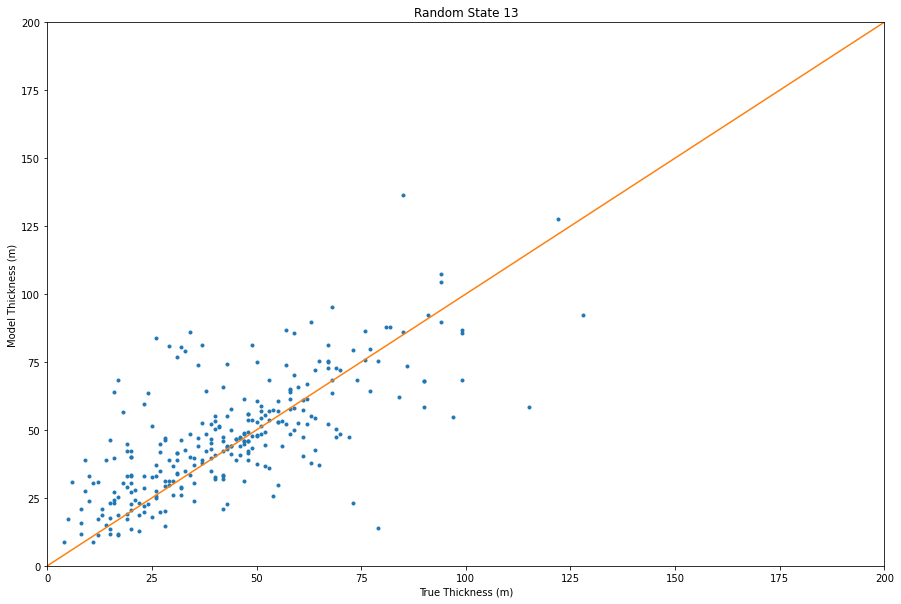

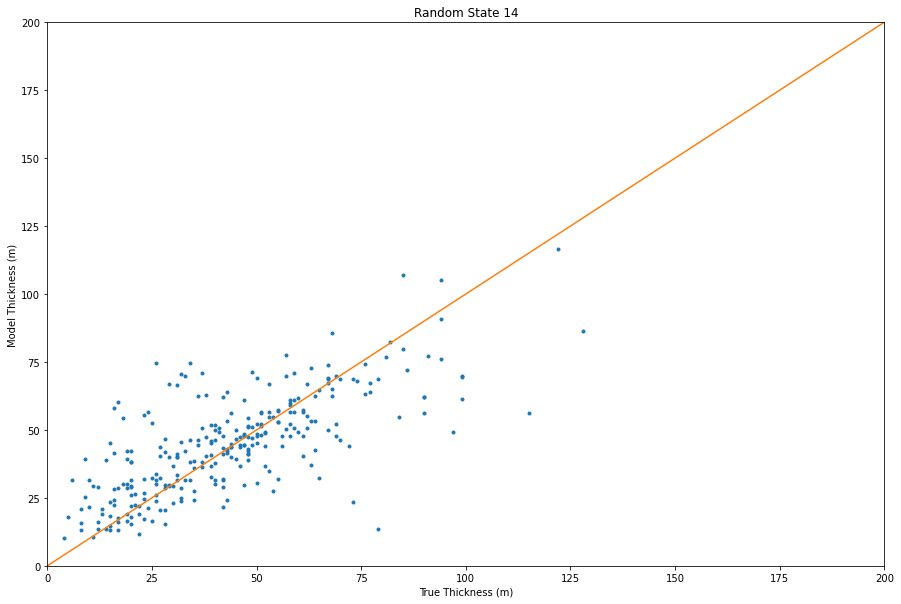

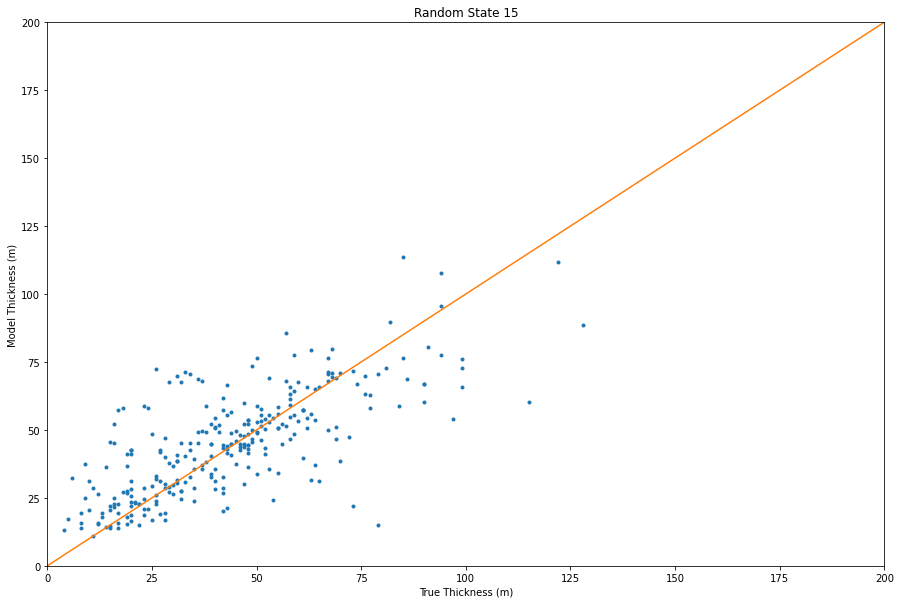

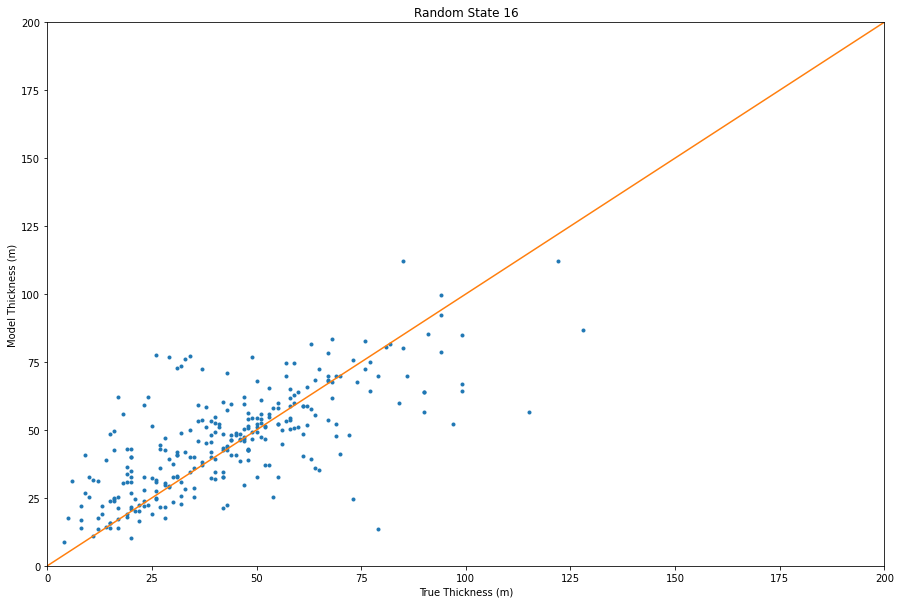

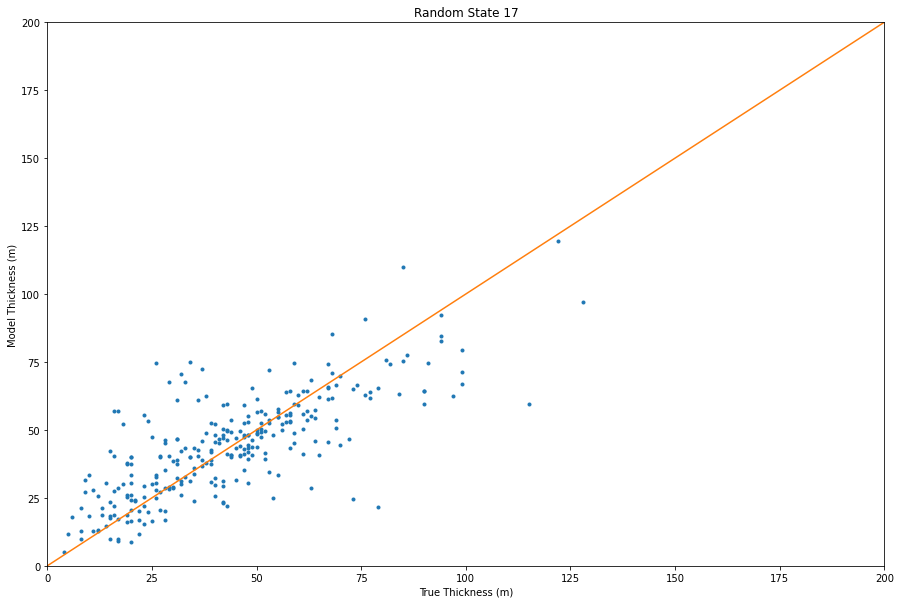

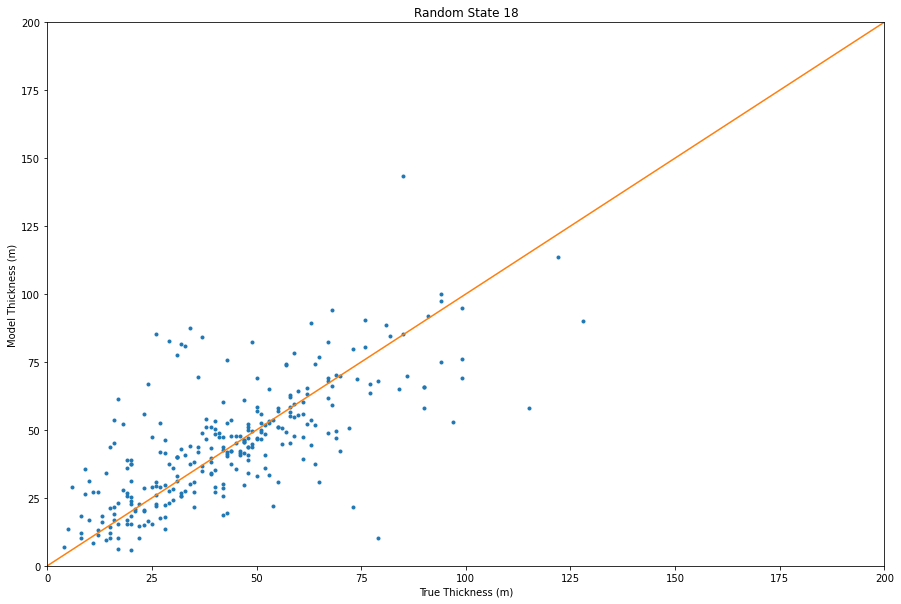

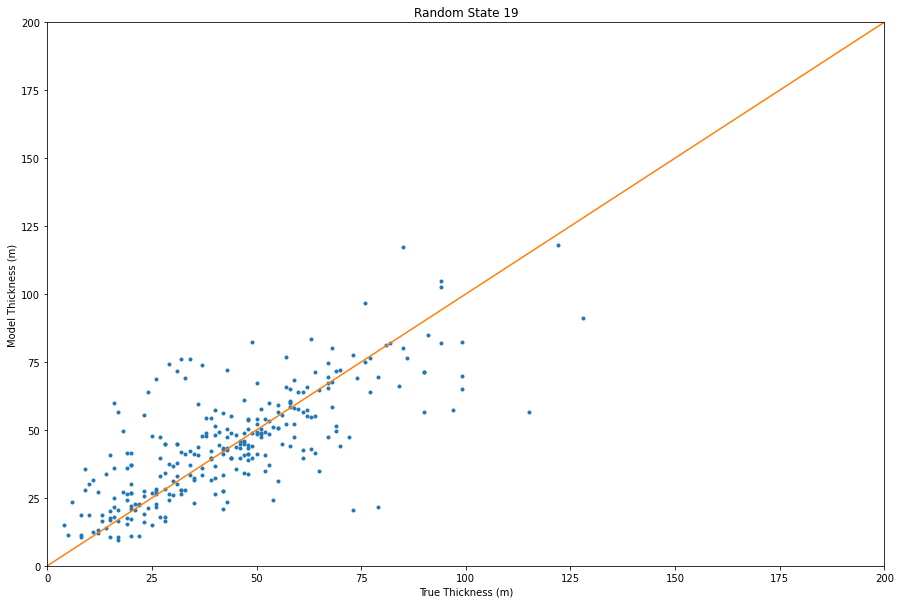

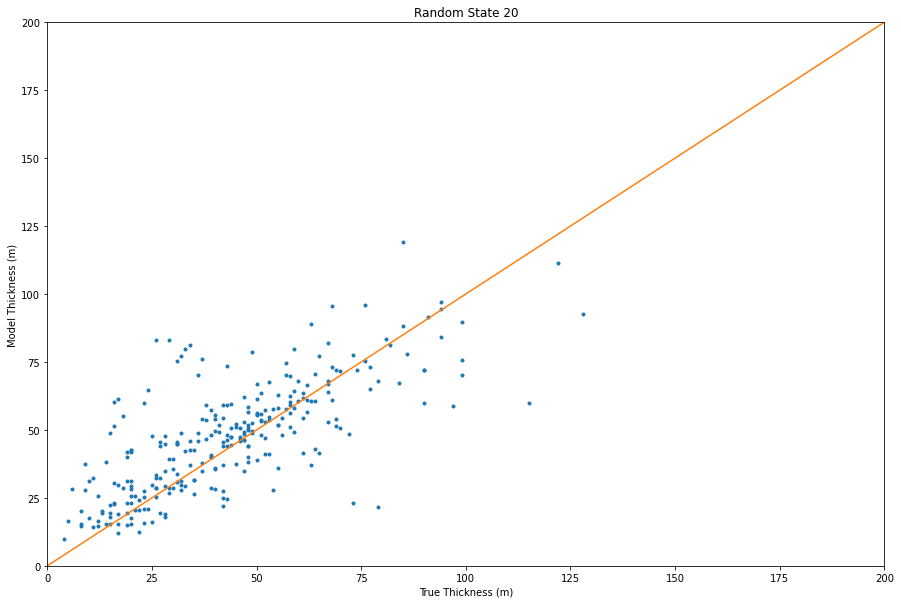

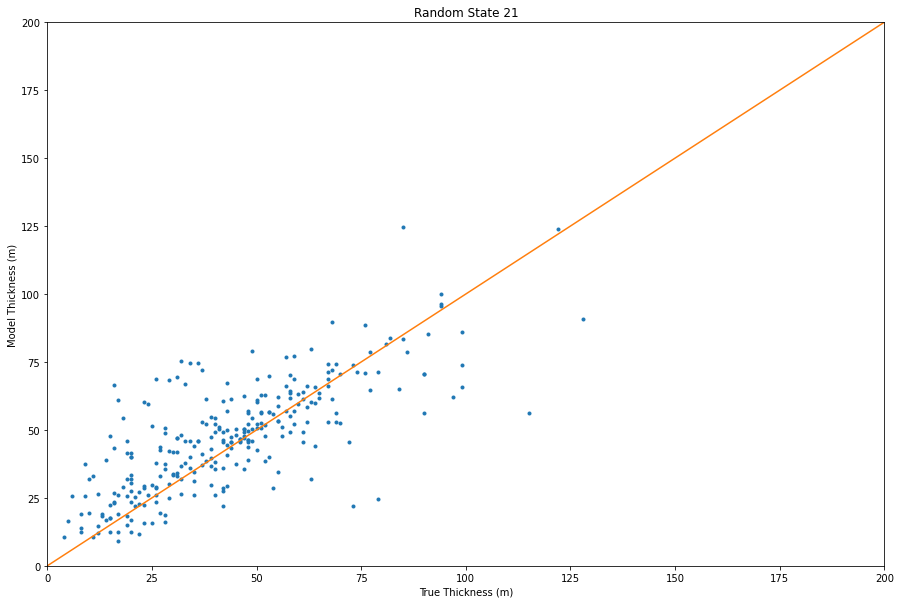

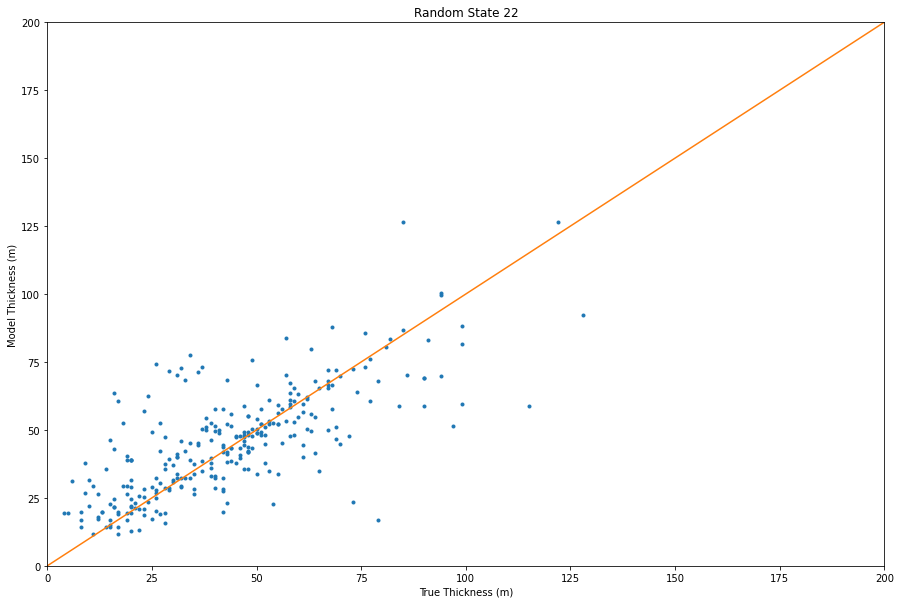

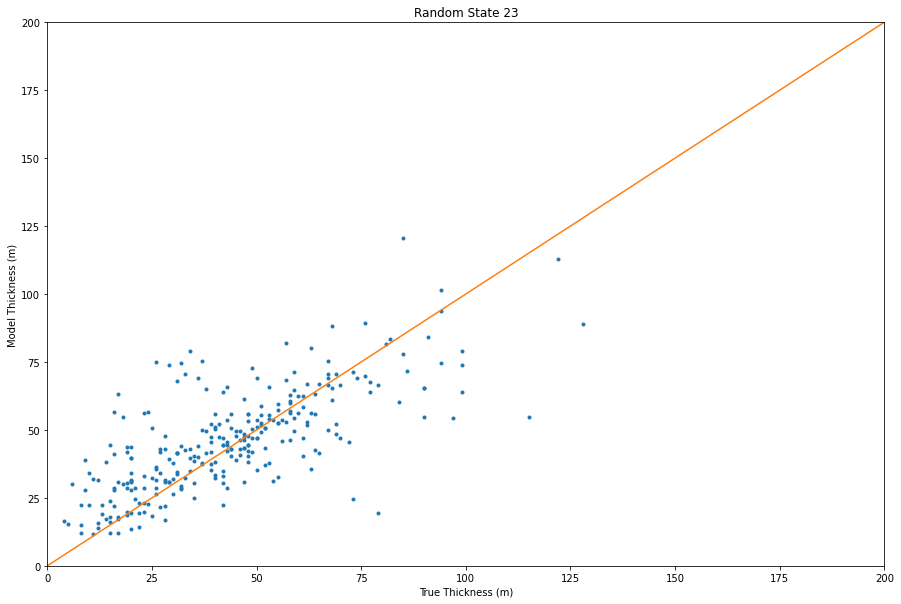

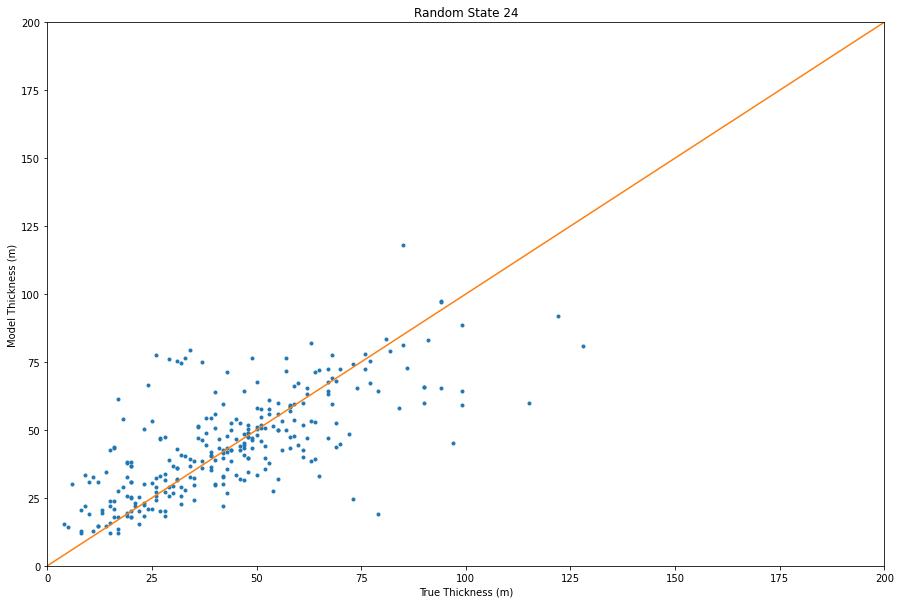

In [22]:
"""
Here we load top rated model and look at predicted accuracies of each random state
"""
print('Please select index from deviations table to inspect further')

selection = int(input())

arch = deviations['layer architecture'].loc[selection]
top_learning_rate = deviations['learning rate'].loc[selection]
epochs = deviations['epochs'].loc[selection]
dnn_model = {}
rootdir = 'saved_models/' + module + '/sm_' + arch + '/'
print('loading and evaluating models...')
for i in tqdm(os.listdir(rootdir)):
    if 'MULTI' in i and 'dnn' in i and str(top_learning_rate) in i:
        dnn_model[arch + '_' + i] = tf.keras.models.load_model(rootdir + i)

train_features, test_features, train_labels, test_labels = gl.data_splitter(dataset)
features = [train_features, test_features]
features = pd.concat(features)
labels = [train_labels, test_labels]
labels = pd.concat(labels)
for rs in RS:
    hhh = (
        str(arch) + 
        '_' + 
        dataset.name +
        '_' + 
        dropout +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )        
    y = dnn_model[hhh].predict(features, verbose = 0)
    fig,ax=plt.subplots(1,1,figsize=(15,10))
    fig.patch.set_facecolor('w')
    plt.plot(labels,y,'.')
    plt.plot((0,200),(0,200),'-')
    plt.xlabel('True Thickness (m)')
    plt.ylabel('Model Thickness (m)')
    ax.set_title('Random State ' +str(rs))
    plt.xlim((0,200))
    plt.ylim((0,200))

/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


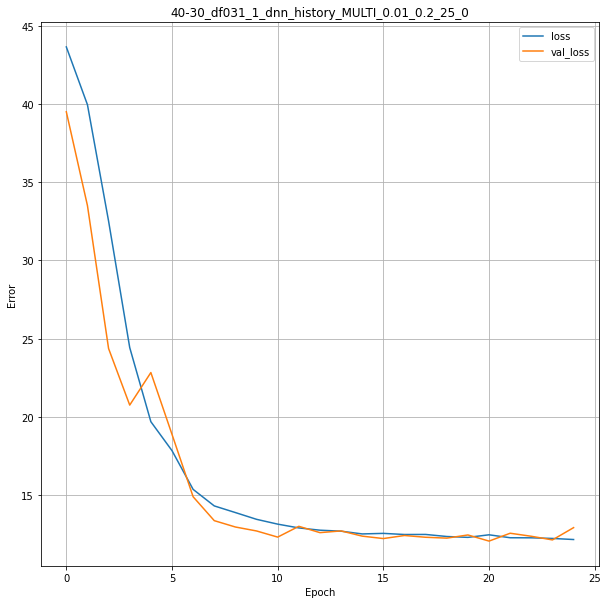

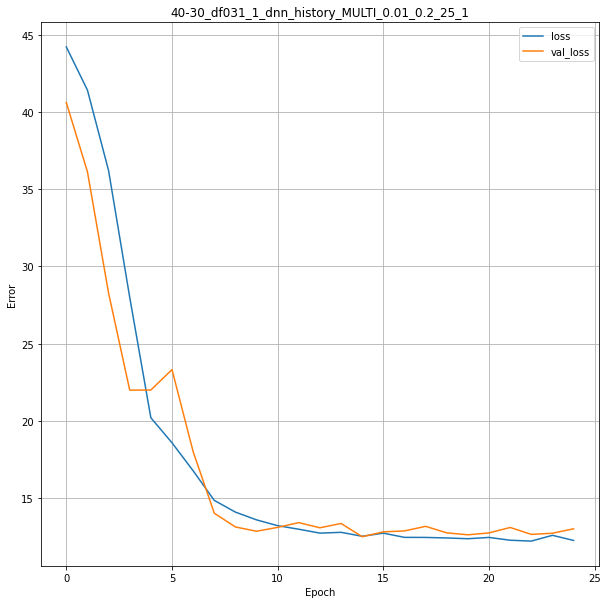

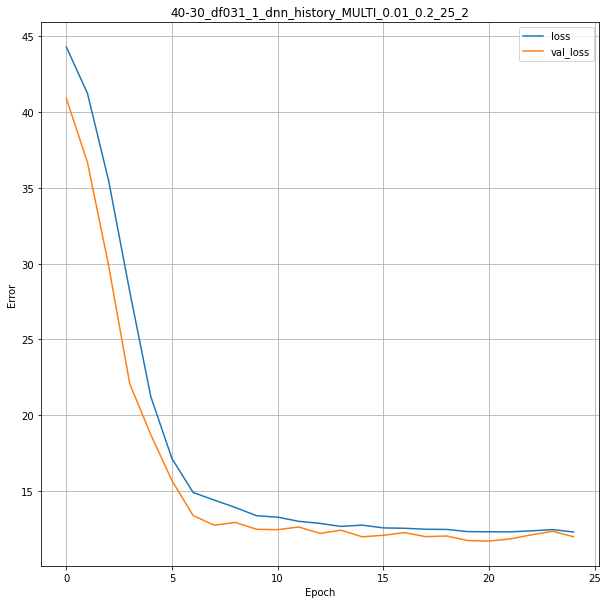

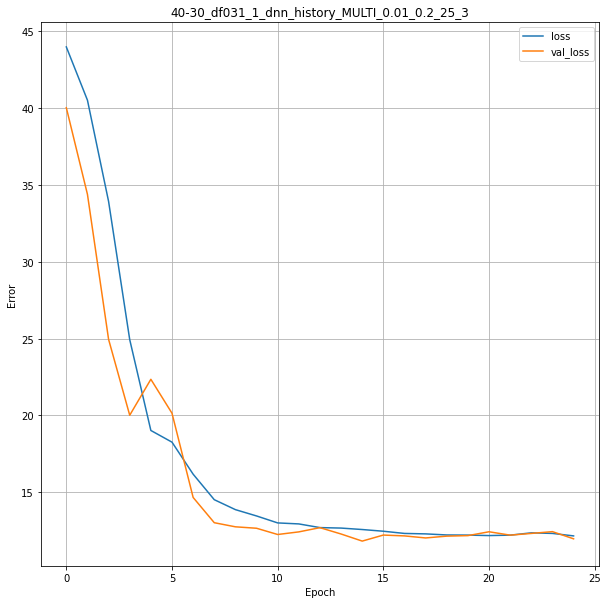

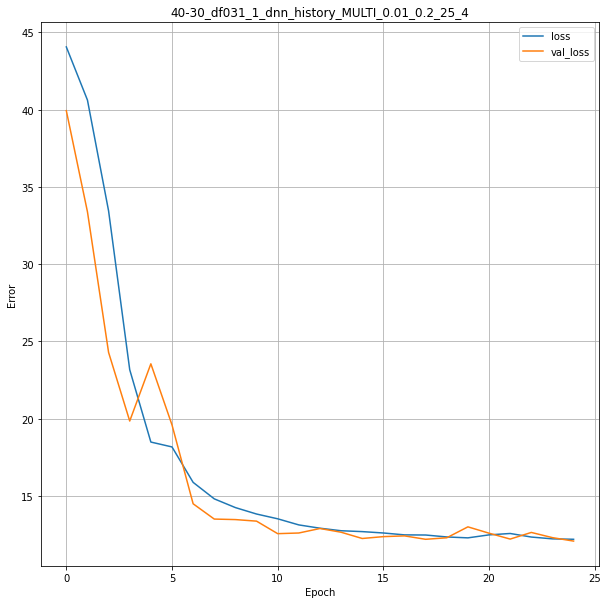

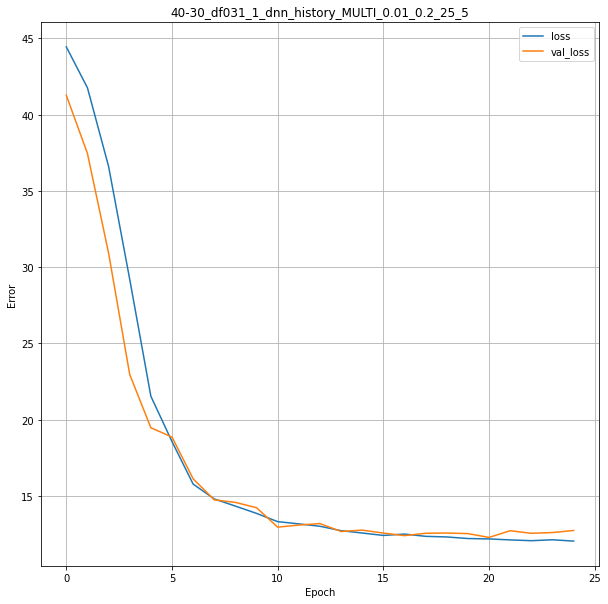

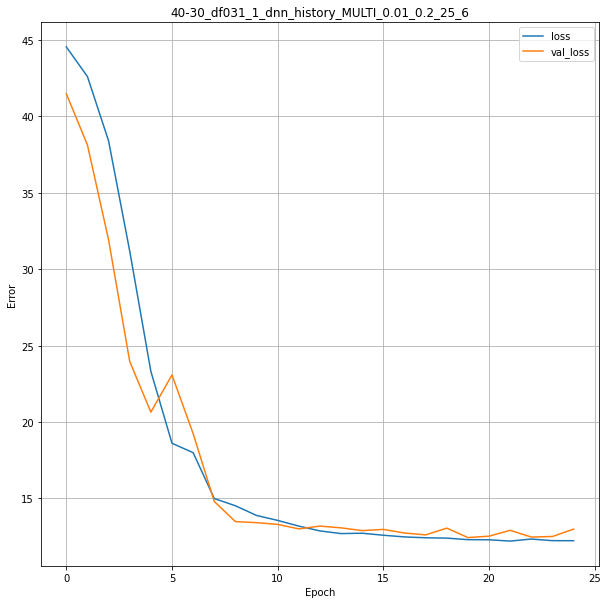

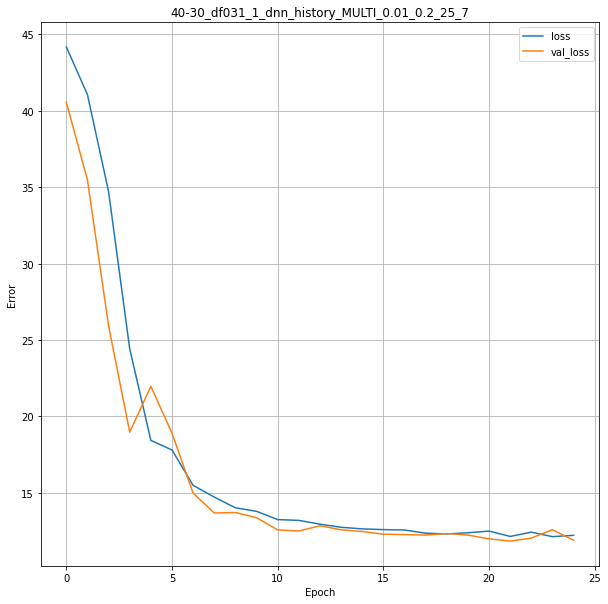

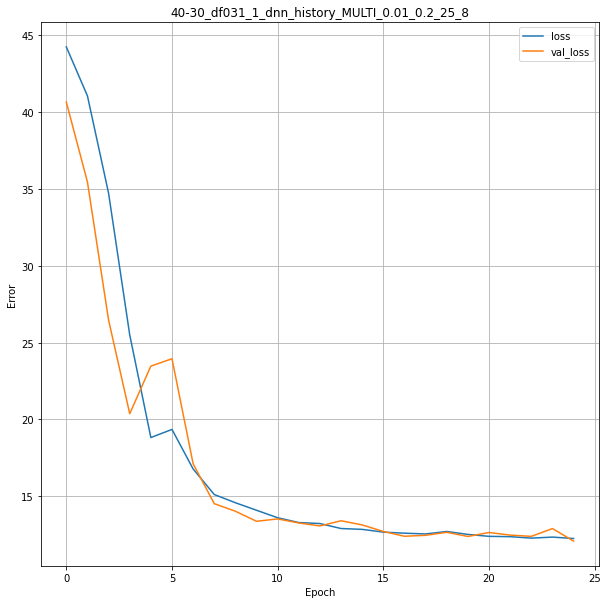

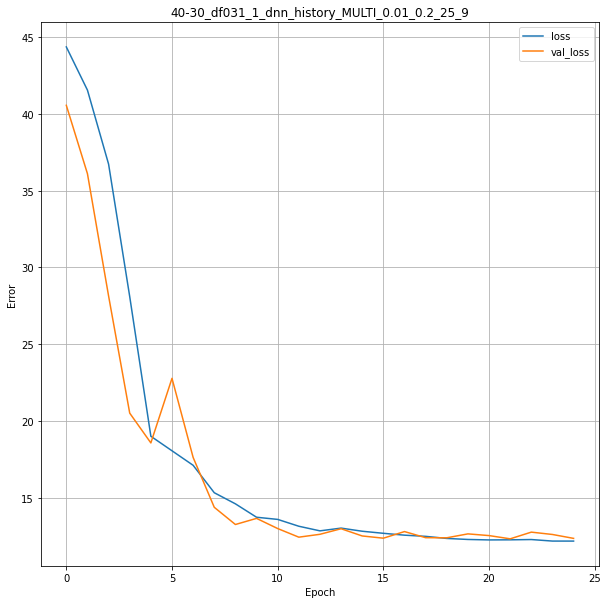

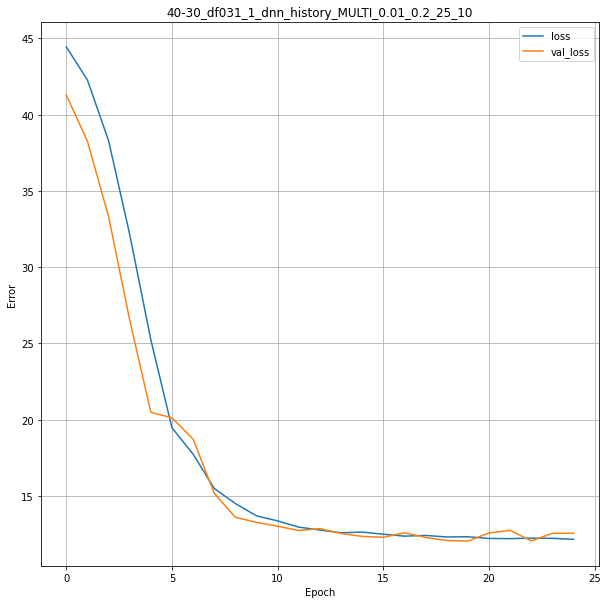

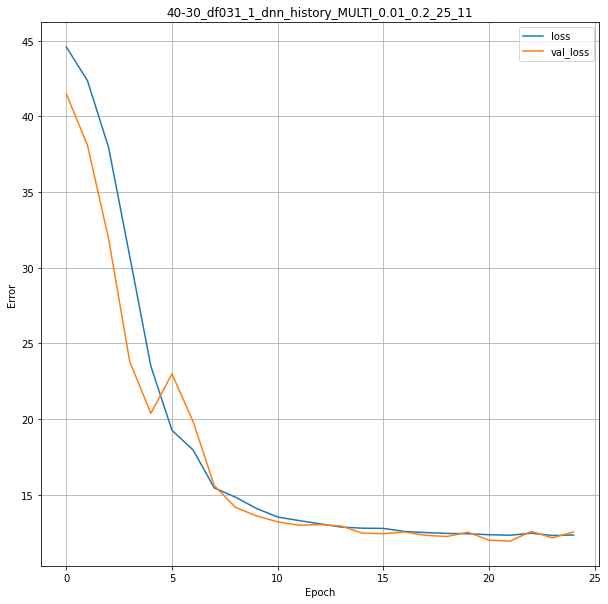

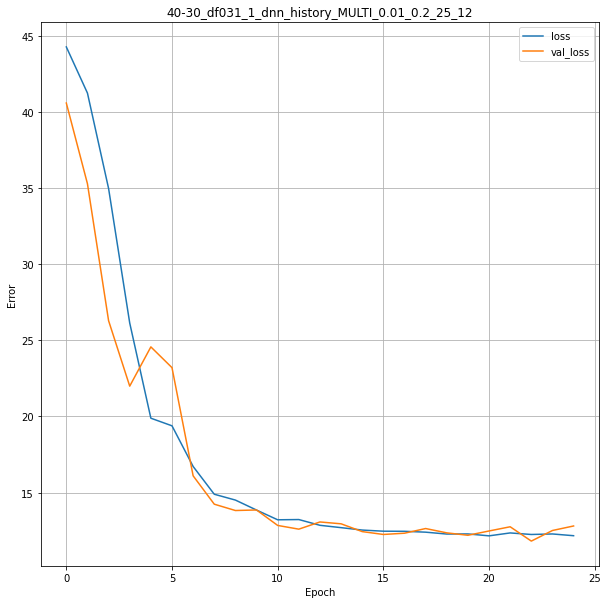

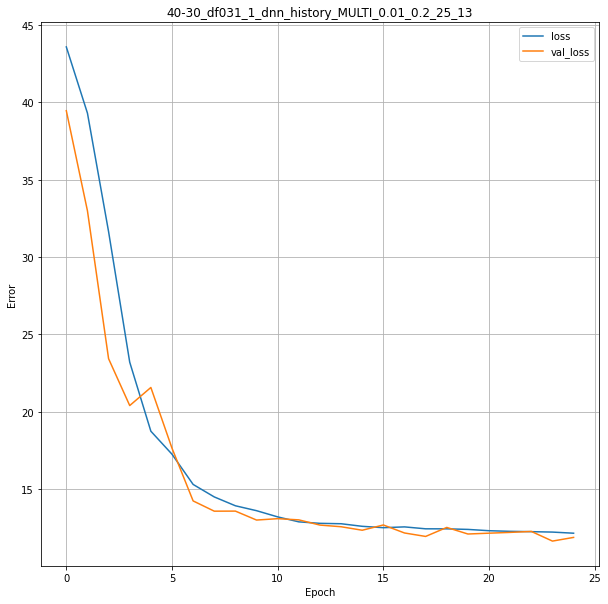

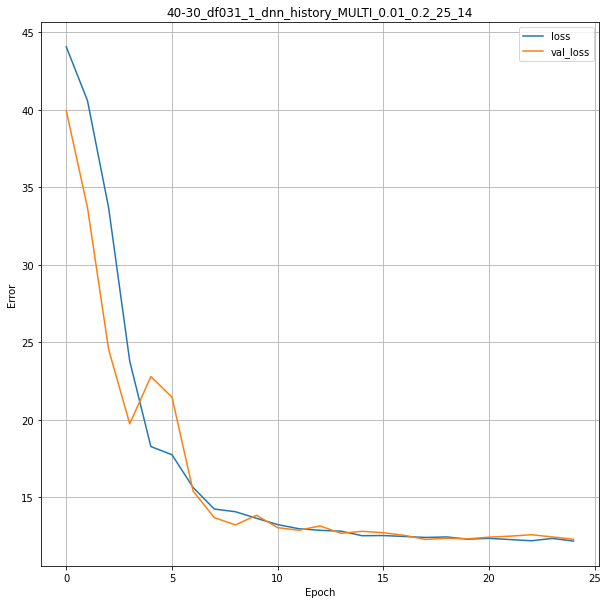

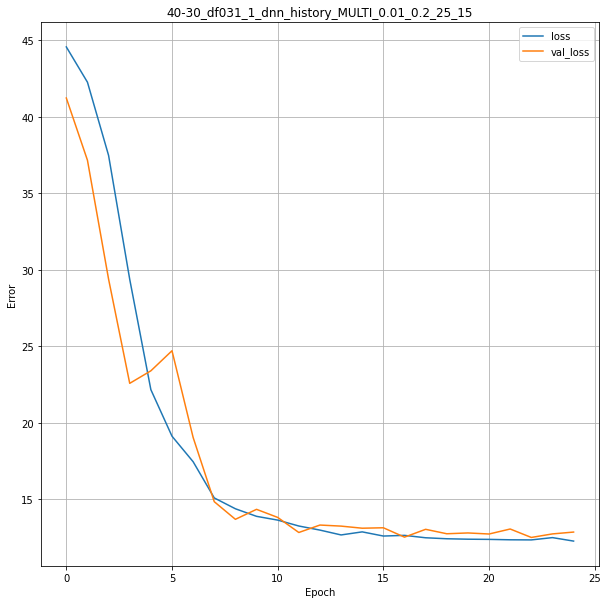

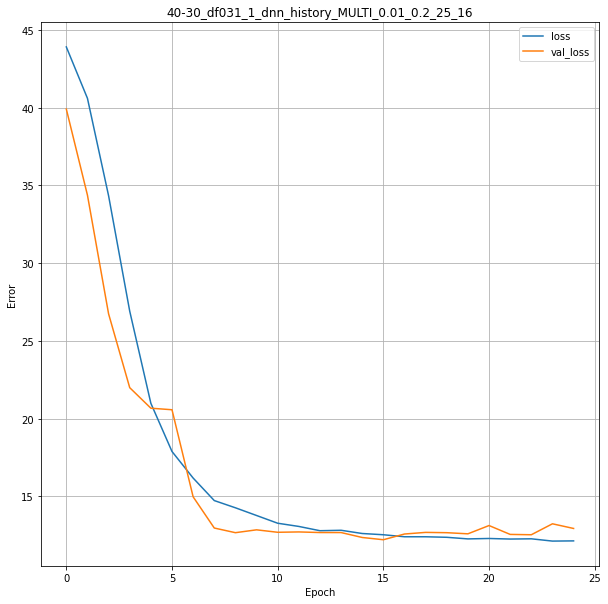

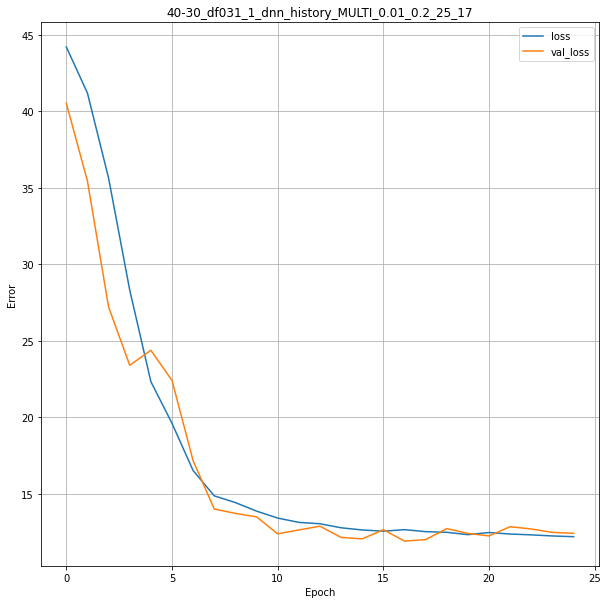

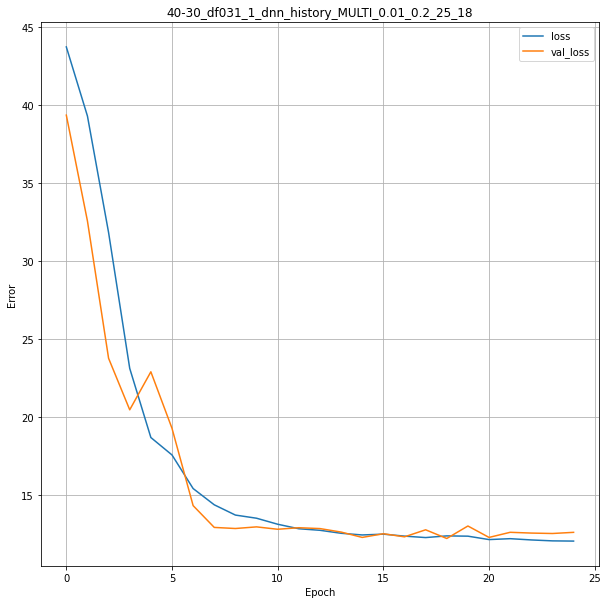

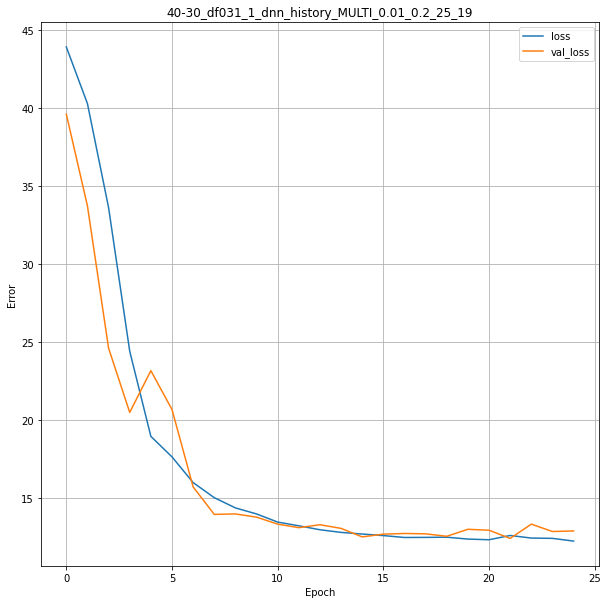

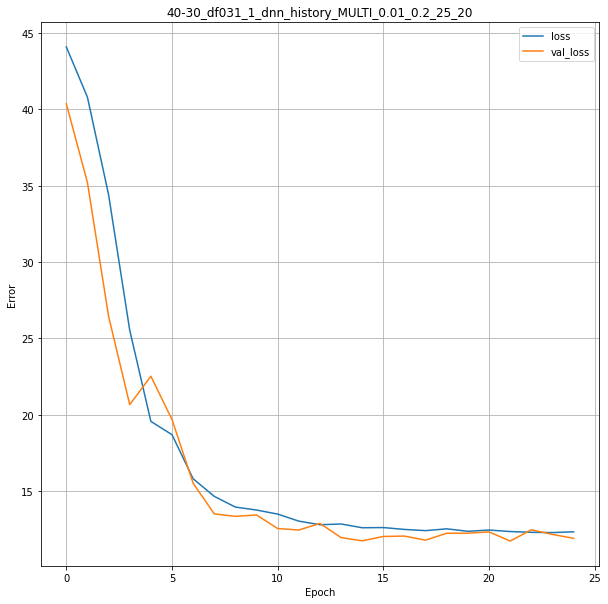

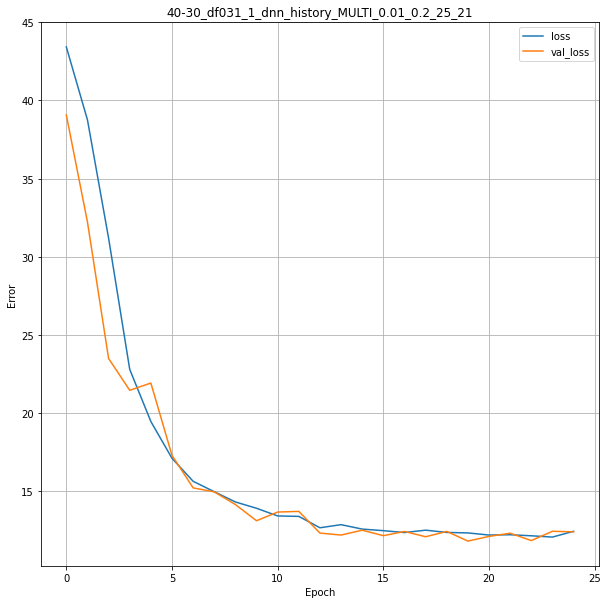

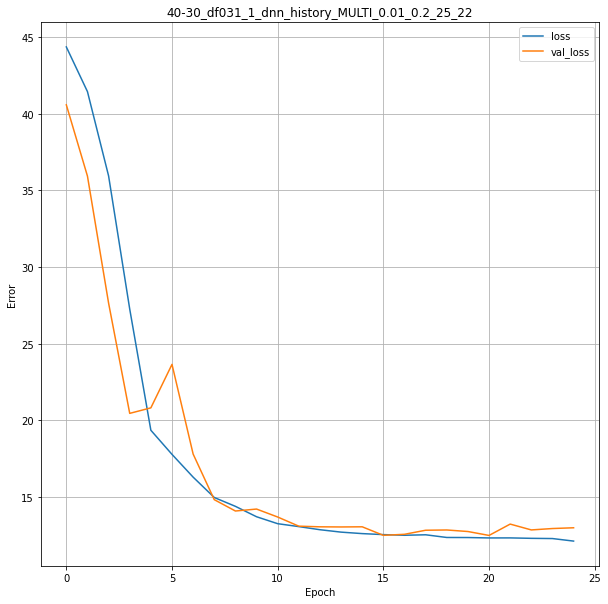

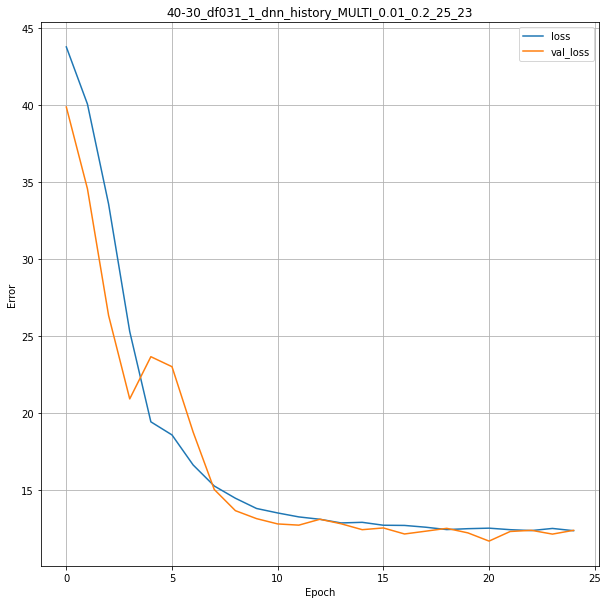

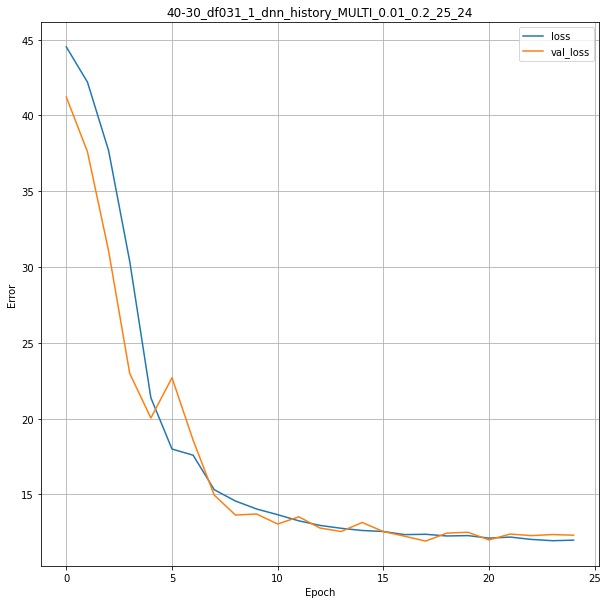

In [13]:
rootdir = 'saved_results/' + res + '/sr_' + arch + '/'
dnn_history = {}
for rs in RS: 
    history_name = (
        arch + 
        '_' +
        dataset.name +
        '_' +
        dropout +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    model_name = (
        dataset.name +
        '_' +
        dropout +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    dnn_history[history_name] = pd.read_csv(rootdir + model_name)

for hist in dnn_history:    
    fig,ax=plt.subplots(1,1,figsize=(10,10))
    fig.patch.set_facecolor('w')
    ax.set_title(hist)
    gl.plot_loss(dnn_history[hist])

In [ ]:
ccccombo_breaker()
# past this point is under construction. 
# here be monsters

In [ ]:
# """
# This cell contains code to produce histograms of all the architectures different histories
# """

# for i in deviations.index:
# #     print(i)
#     df = deviations.iloc[i]
#     arch = df['layer architecture']
#     top_learn_rate = df['learning rate']
#     epochs = df['epochs']

#     dfs = predictions[
#         (predictions['architecture'] == arch) &
#         (predictions['learning rate'] == top_learn_rate) &
#         (predictions['epochs'] == epochs)
#     ]
#     fig,ax = plt.subplots()
#     ax.set_title('df:' + str(i) + ' Layer architecture: ' + arch )
#     ax.set_ylabel('prediction count')
#     ax.set_xlabel('thickness (m)')
#     fig.patch.set_facecolor('w')
#     plt.hist(dfs['avg test thickness'])


In [ ]:
df1 = gl.data_loader_1()

df1 = df1.rename(columns = {
        'GLACIER_NAME':'name_g',
        'Name':'name_r',
        'AREA':'area_g',
        'Area':'area_r',
        'BgnDate':'date_r',
        'SURVEY_DATE':'date_g'


})
df = df1
df
df['size_anomaly'] = abs(df['area_g'] - df['area_r'])
df = df[df['size_anomaly'] < 1]
df = df.drop([
    'size_anomaly',
    'area_g'
#         'area_r'
], axis = 1)
df
RGI_predicted

In [ ]:
RGI_predicted

In [ ]:
tau_b = 10*5
rho = 0.9167
g = 9.81




#     lambda : np.sqrt(
#         ((2 * tau_b) / (rho * g)) * 
#     )
RGI_predicted['h max'] = np.sqrt((2 * tau_b) / (rho * g)) * RGI_predicted['Lmax']

    
RGI_predicted['h avg'] = (2/3) * RGI_predicted['h max']
    


# print(RGI_test)
RGI_predicted
# h_avg = (2/3) ** h_max

In [ ]:
print('loading RGI...')
rootdir = '/data/fast0/datasets/rgi60-attribs/'
RGI_extra = pd.DataFrame()
for file in tqdm(os.listdir(rootdir)):
    f = pd.read_csv(rootdir+file, encoding_errors = 'replace', on_bad_lines = 'skip')
    RGI_extra = RGI_extra.append(f, ignore_index = True)
    

RGI = RGI_extra[[
    'RGIId',
    'CenLat',
    'CenLon',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Area',
    'Aspect',
    'Lmax'
]]

df1 = RGI_predicted_df1
(sum((df1['area'] * df1['avg predicted thickness']) * 10**6) / 10**9)


AIC = deviations_df1['model parameters'] - deviations_df1['test mae avg']

AIC.sort_values()

fig,ax = plt.subplots()
fig.patch.set_facecolor('w')
plt.plot(
    deviations_df1['test predicted thickness std dev'], 
    deviations_df1['test mae avg'],
    '.',
)

In [ ]:
"""
This is a density plot of the most recent predictions made. Can easily be modified in a loop
to show multiple random states and whatnot
"""
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,300),(0,300),'-')

In [ ]:
"""
This cell computes the true average thickness of the glaciers in use
"""


pth = '/data/fast1/glacierml/T_models/'
T_lab = pd.read_csv(pth + 'T.csv', low_memory = False)
T_lab = T_lab[[
    'GlaThiDa_ID',
    'LAT',
    'LON',
    'AREA',
    'MEAN_SLOPE',
    'MEAN_THICKNESS'
]]
T_lab = T_lab.dropna()

tru_thickness = np.sum(T_lab['MEAN_THICKNESS']) / len(T_lab['MEAN_THICKNESS'])
tru_thickness